In [49]:
import matplotlib.pyplot as plt
import os
import torch
import numpy as np 
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.patches as patches

In [4]:
base_dir = '/media/data1/max_m/thesis/RSNA/saliencymap/multi_inference/2019-10-30_18-50-01'
files = os.listdir(base_dir)
smaps_dir = [ x for x in files if '20_smaps_' in x]
smaps = [torch.load(os.path.join(base_dir, x)) for x in smaps_dir]
# convert to numpy arrays
sm = [x.cpu().numpy() for x in smaps]
[print(x.shape) for x in smaps]

torch.Size([20, 3, 64, 64])
torch.Size([20, 3, 64, 64])
torch.Size([20, 3, 64, 64])
torch.Size([20, 3, 64, 64])


[None, None, None, None]

In [5]:
# compute batchwise max and min for normalization
min_s = [x.min() for x in sm]
max_s = [x.max() for x in sm]
print(min_s, max_s)

[8.135451e-08, 2.1264826e-18, 1.8106183e-18, 1.6711533e-18] [0.98584205, 0.91370535, 0.8930694, 0.914049]


In [8]:
inputs = torch.load('/media/data1/max_m/thesis/RSNA/saliencymap/multi_inference/2019-10-30_15-29-03/20_inputs_0.pt')
print(inputs.shape)
inputs_cpu = inputs.cpu().numpy()

torch.Size([20, 3, 512, 512])


# visualize 5 rows and 4 columns, where cols are trainings

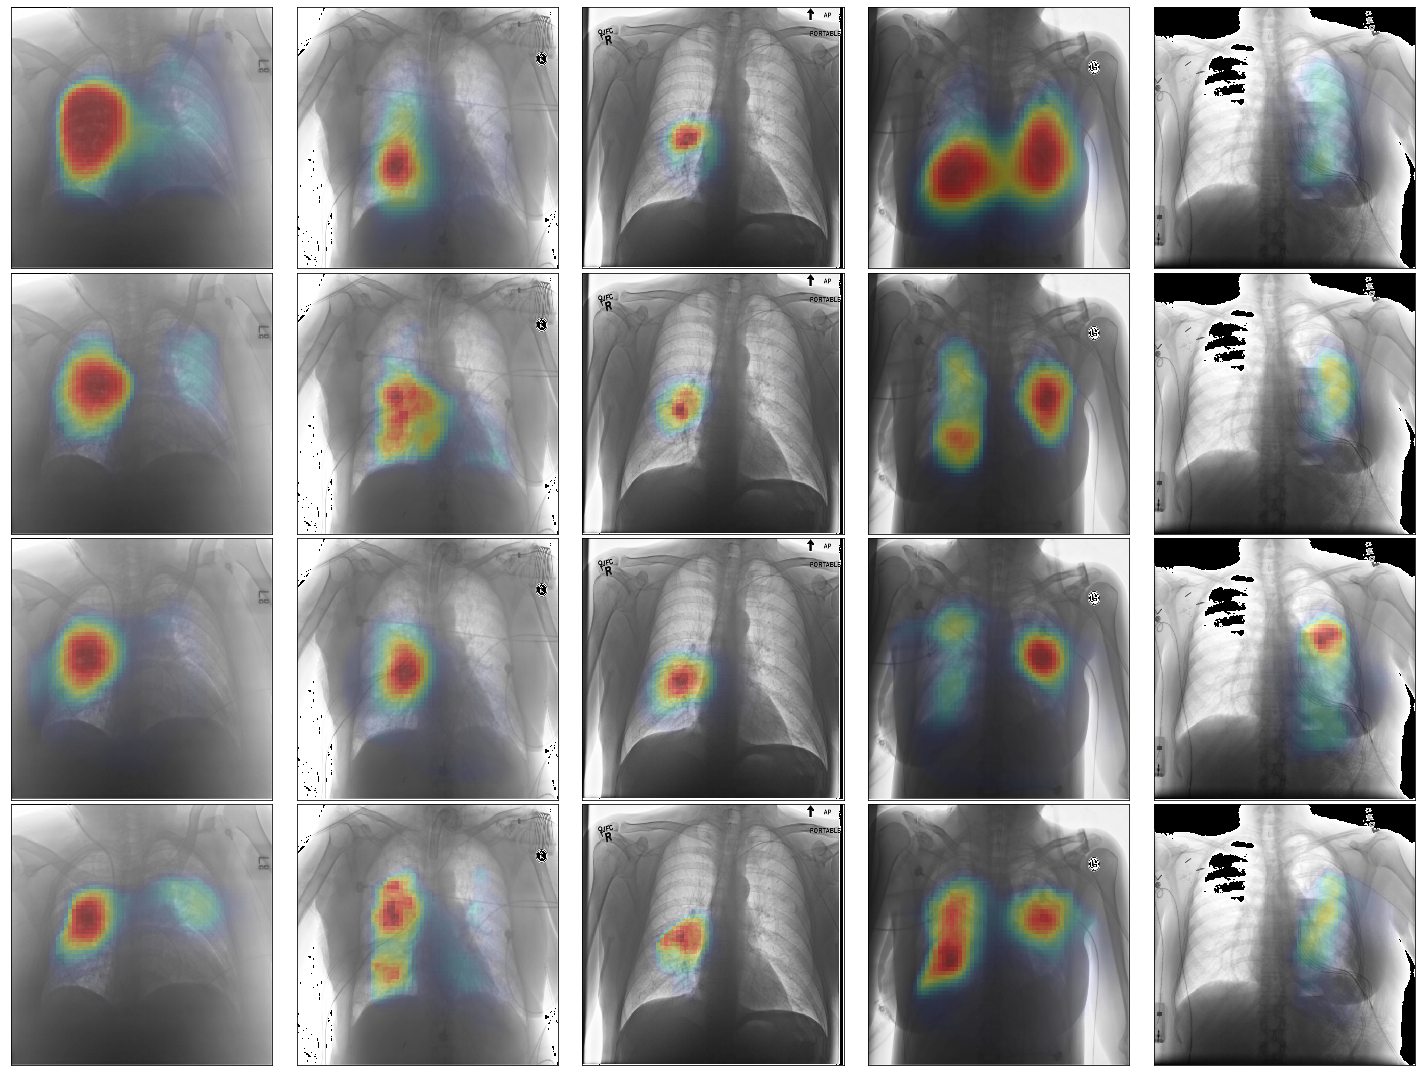

In [23]:
fig, axs = plt.subplots(4, 5, figsize=(20, 15))

for m in range(len(sm)):
    extent = 0, 512, 512, 0
       


    for i in range(5):
        #normalize
        max_s = np.max(sm[m][i])
        min_s = np.min(sm[m][i])
        norm = Normalize(min_s, max_s)(sm[m][i, 0, :, :].squeeze())
        colors = plt.cm.jet(norm)
        norm[norm<0.01] = 0
        colors[..., -1] = norm

        im2 = axs[m,i].imshow(inputs_cpu[i, 0, :, :].squeeze(), cmap='gray', alpha=1)
        im = axs[m,i].imshow(colors, alpha=0.5, interpolation='nearest', extent=extent)
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
plt.tight_layout()
# fig.colorbar(im, cax=cbar_ax)
plt.show()

In [9]:
len(sm)

4

# add bounding boxes

In [41]:
bbox_df = pd.read_csv('/media/data2/data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
pids = pd.read_csv('/media/data1/max_m/thesis/RSNA/saliencymap/multi_inference/pids.csv')
pids = pids['0'].tolist()

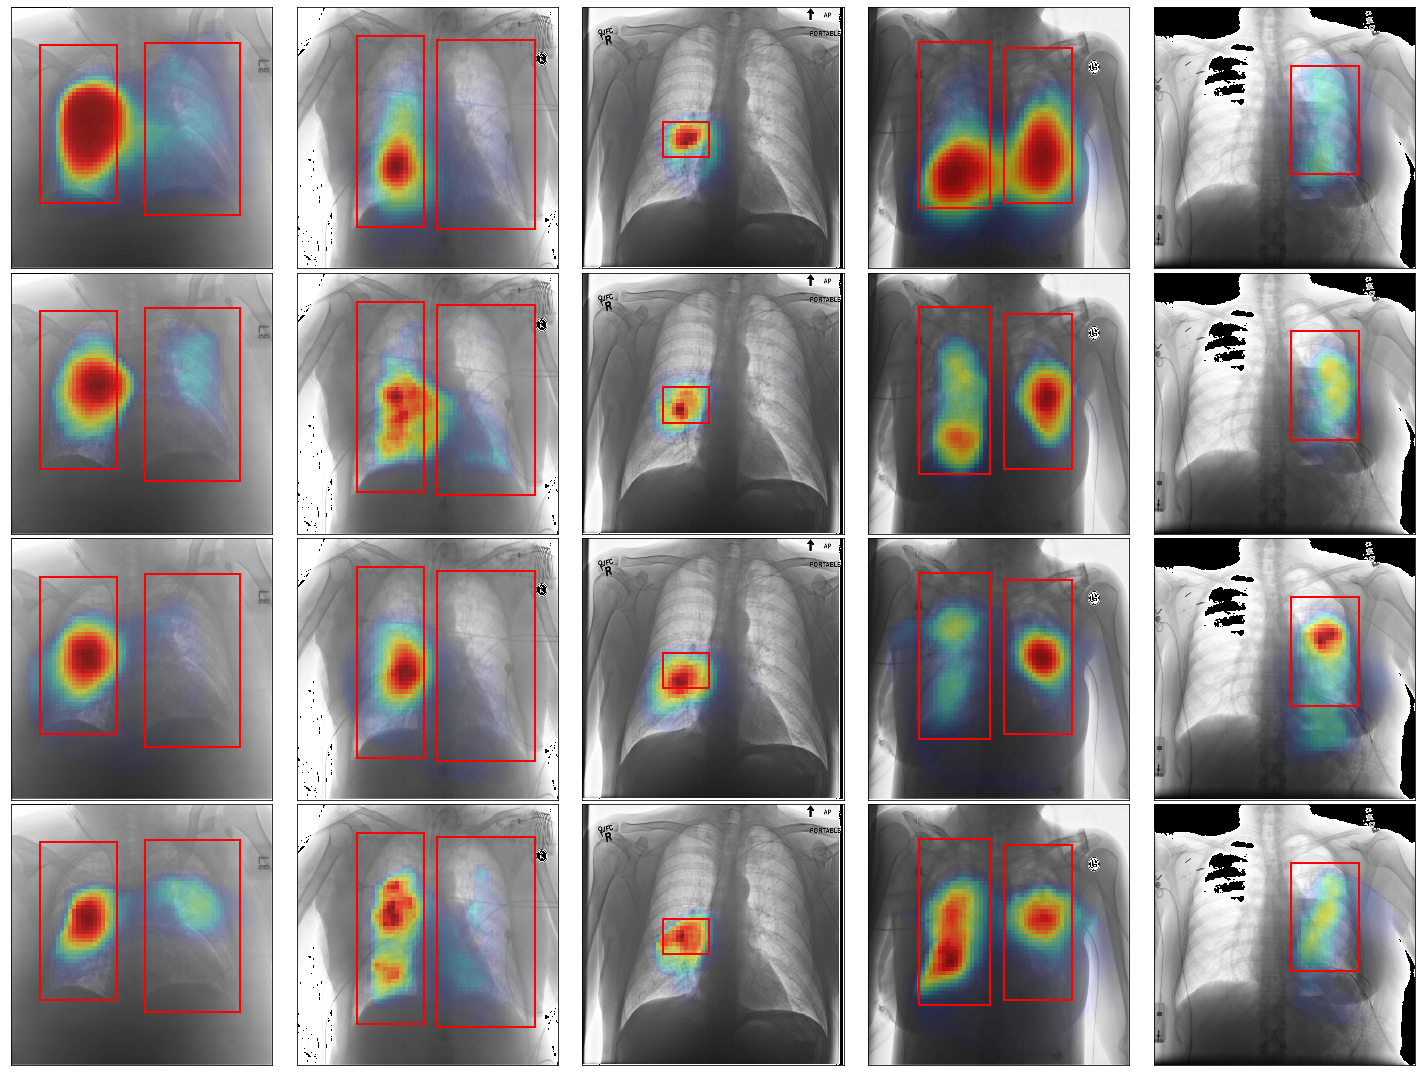

In [56]:
fig, axs = plt.subplots(4, 5, figsize=(20, 15))

for m in range(4):
    extent = 0, 512, 512, 0
       


    for i in range(5):
        #normalize
        max_s = np.max(sm[m][i])
        min_s = np.min(sm[m][i])
        norm = Normalize(min_s, max_s)(sm[m][i, 0, :, :].squeeze())
        colors = plt.cm.jet(norm)
        norm[norm<0.01] = 0
        colors[..., -1] = norm
        
        #get bboxes
        pid = [pids[i]]
        bbox = bbox_df[bbox_df['patientId'].isin(pid)]
        # # check if there is a bbox:
        if np.any(bbox['Target'].isin([1])):
            # bbox present and needs to be plotted
            plot_bbox = True
            x = bbox['x'].values // 2
            y = bbox['y'].values // 2
            w = bbox['width'].values // 2
            h = bbox['height'].values // 2
            # convert upper left coordinates to lower_left coordinates
            x_ll = x
            y_ll = y
        else:
            plot_bbox = False


        if plot_bbox:
            if bbox.shape[0] > 1:
                # multiple bboxes
                for r in range(bbox.shape[0]):
                    rect = patches.Rectangle((x_ll[r], y_ll[r]), w[r], h[r], linewidth=2, edgecolor='r',
                                             facecolor='none')
                    axs[m,i].add_patch(rect)
            else:
                rect = patches.Rectangle((x_ll, y_ll), w, h, linewidth=2, edgecolor='r', facecolor='none')
                axs[m,i].add_patch(rect)

        im2 = axs[m,i].imshow(inputs_cpu[i, 0, :, :].squeeze(), cmap='gray', alpha=1)
        im = axs[m,i].imshow(colors, alpha=0.8, interpolation='nearest', extent=extent)
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
fig.subplots_adjust(right=0.8)
plt.tight_layout()
# fig.colorbar(im, cax=cbar_ax)

plt.savefig(os.path.join(base_dir, '4.png'))
plt.show()